# Importing

In [9]:
import pyiast
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import time
import os
import scipy.optimize as optim
import matplotlib.pyplot as plt

df_NAME=pd.read_csv("HEAT_0215.csv")

bins_CO2 = []
bins_H2S = []
for nam in df_NAME["NAME"]:
    f_tmp = open("iso_"+nam+"_saved.bin",'rb')
    bin_tmp = np.array(pickle.load(f_tmp))
    bins_CO2.append(bin_tmp[[False, True, True]]) ## Pick 1 = CO2, 2 = CH4 
    f_tmp.close()
for nam in df_NAME["NAME"]:
    f_tmp = open("iso_"+nam+"_saved.bin",'rb') ## 0 = H2S , 1 = CO2, 2 = CH4
    bin_tmp = np.array(pickle.load(f_tmp))
    bins_H2S.append(bin_tmp[[True, False, True]]) ## Pick 0 = H2S and 2 = CH4
    f_tmp.close()

Names_CO2=df_NAME["NAME"].to_numpy()
Names_H2S=df_NAME["NAME"].to_numpy()
dH_CO2 = np.array([df_NAME["CO2_Heat"], df_NAME["CH4_Heat"]]).T
dH_H2S = np.array([df_NAME["H2S_Heat"],df_NAME["CH4_Heat"]]).T

# Function

## iso_mix: Mixture isotherm

In [10]:
Arrh = lambda T,dH ,T_ref: np.exp(-dH/8.3145*(1/T - 1/T_ref)) # Arrhenius equation (Clasius-Clapeyron Equation)

## Isothermal mixture isotherm
def iso_mix(P_par, T, iso_list, dH_list,Tref_list):
    P_norm = []
    for (p,dh,tref) in zip(P_par, dH_list,Tref_list):
        p_n = Arrh(T,dh,tref)*p 
        P_norm.append(p_n)
    P_norm_arr = np.array(P_norm)
    #print(P_norm_mat.T)
    if P_norm_arr.ndim > 1:
        for i in range(len(P_norm[0])):
            p_tmp = P_norm_arr[i,:]
            p_tmp[p_tmp<0.000001] = 0.000001
            q_IAST_tmp = pyiast.iast(p_tmp,
                                     iso_list,
                                     warningoff=True)
    else:
        try:
            p_tmp = P_norm_arr
            p_tmp[p_tmp<0.000001] = 0.000001
            #print(p_tmp)
            q_IAST_tmp = pyiast.iast(p_tmp,
                                    iso_list,
                                     warningoff=True)
        except:    
            try:
                #print('Initial guess error with P = ',P_par)
                x_IG = np.ones(len(p_tmp))/len(p_tmp)
                q_IAST_tmp = pyiast.iast(p_tmp,
                                        iso_list,adsorbed_mole_fraction_guess = x_IG,
                                        warningoff=True)
            except:
                try:
                    arg_min = np.argmin(p_tmp)
                    p_tmp[p_tmp<0.000001] = 0.000001
                    x_IG = 0.05*np.ones(len(p_tmp))
                    x_IG[arg_min] = 1 - 0.05*(len(p_tmp)-1)
                    #print(x_IG)
                    q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                except:
                    try:
                        arg_max = np.argmax(p_tmp)
                        p_tmp[p_tmp<0.000001] = 0.000001
                        x_IG = 0.05*np.ones(len(p_tmp))
                        x_IG[arg_max] = 1 - 0.05*(len(p_tmp)-1)
                        #print(x_IG)
                        q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                    except:
                        try:
                            arg_max = np.argmax(p_tmp)
                            p_tmp[p_tmp<0.000001] = 0.000001
                            x_IG = 0.15*np.ones(len(p_tmp))
                            x_IG[arg_max] = 1 - 0.15*(len(p_tmp)-1)
                            #print(x_IG)
                            q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)
                        except:
                            try:
                                arg_min = np.argmin(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_min] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                            except:
                                try:
                                    arg_max = np.argmax(p_tmp)
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = 0.01*np.ones(len(p_tmp))
                                    x_IG[arg_max] = 1 - 0.01*(len(p_tmp)-1)
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                                except:
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = [0.9999, 0.0001]
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)    
           
    return q_IAST_tmp

## Av_grad: Average gradient

In [12]:
def Av_grad(iso_inin, dH_inin, P_inin, T_inin):
    Np = len(P_inin)
    KA_tmp = iso_inin.params['Ka']*Arrh(T_inin,dH_inin, 298 ) ## T (K); dH (J/mol); 
    KB_tmp = iso_inin.params['Kb']*Arrh(T_inin,dH_inin, 298 ) ## T (K); dH (J/mol);
    num = (KA_tmp + 4*KB_tmp*P_inin)*(1+KA_tmp*P_inin + KB_tmp*P_inin**2) - P_inin*(KA_tmp + 2*KB_tmp*P_inin)**2
    den = (1+KA_tmp*P_inin + KB_tmp*P_inin**2)**2
    grad_res = num/den
    return np.mean(grad_res)

### test ###
P_ran_tmp = np.linspace(1,50,10)
avgrad_tmp = Av_grad(bins_CO2[0][0],dH_CO2[0][0], P_ran_tmp, 343) 
print(avgrad_tmp)
    

0.022348353985045644


# CO2 Param Distributions

In [3]:
for bbb in bins_CO2:
    print(bbb[0].model)

Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic


Quadratic Model 

$q = M \frac{K_{a}+2K_{b}P}{1+K_{a}P+K_{b}P^{2}}$

## Obtaining Ka, Kb, and average gradient (Av_grad)

In [13]:
indd = 0 # CO2

Na_sel_CO2 = []
Ka_CO2 = []
Kb_CO2 = []
P_ran_tmp = np.linspace(0,50,51)
AvGrad_CO2 = []
for bbb,dHH,naa in zip(bins_CO2, dH_CO2,Names_CO2):

    iso_list_tmp = bbb
    model_tmp = iso_list_tmp[indd].model
    if model_tmp == 'Quadratic':
        Ka_tmp = iso_list_tmp[indd].params['Ka']
        Kb_tmp = iso_list_tmp[indd].params['Kb']
        exp_Arrh = Arrh(343,dHH[indd]*1000, 298)
        AvGrad_tmp = Av_grad(bbb[indd],dHH[indd],P_ran_tmp,343)
        Ka_res = Ka_tmp*exp_Arrh
        Kb_res = Kb_tmp*exp_Arrh**2

        Na_sel_CO2.append(naa)
        Ka_CO2.append(Ka_res)
        Kb_CO2.append(Kb_res)
        AvGrad_CO2.append(AvGrad_tmp)

    #print(model_tmp, model_tmp == 'Quadratic')

In [5]:
std_Ka_CO2 = np.std(Ka_CO2)
mean_Ka_CO2 = np.mean(Ka_CO2)
std_Kb_CO2 = np.std(Kb_CO2)
mean_Kb_CO2 = np.mean(Kb_CO2)

print('Standard Deviation (Ka vs Kb):')
print(std_Ka_CO2, std_Kb_CO2)
print()
print('Mean Value (Ka vs Kb):')
print(mean_Ka_CO2, mean_Kb_CO2)


Standard Deviation (Ka vs Kb):
0.07836847267781905 0.0037309413565462662

Mean Value (Ka vs Kb):
0.11886698769541407 0.0035248045726015143


In [16]:
print('Standard Deviation of Average Gradient: ')
print(np.std(AvGrad_CO2))
print()

print('Mean value of Average Gradient: ')
print(np.mean(AvGrad_CO2))

Standard Deviation of Average Gradient: 
0.006245863535194035

Mean value of Average Gradient: 
0.03636355359970042


# H2S Param Distributions

In [6]:
for bbb in bins_H2S:
    print(bbb[0].model)

Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic
Quadratic


In [17]:
indd = 0
Na_sel_H2S = []
Ka_H2S = []
Kb_H2S = []
AvGrad_H2S = []
P_ran_tmp = np.linspace(0,50,51)
for bbb,dHH,naa in zip(bins_H2S, dH_H2S,Names_H2S):
    iso_list_tmp = bbb
    model_tmp = iso_list_tmp[indd].model
    if model_tmp == 'Quadratic':
        Ka_tmp = iso_list_tmp[indd].params['Ka']
        Kb_tmp = iso_list_tmp[indd].params['Kb']
        AvGrad_tmp = Av_grad(bbb[indd],dHH[indd],P_ran_tmp,343)
        exp_Arrh = Arrh(343,dHH[indd]*1000, 298)
        Ka_res = Ka_tmp*exp_Arrh
        Kb_res = Kb_tmp*exp_Arrh**2

        Na_sel_H2S.append(naa)
        Ka_H2S.append(Ka_res)
        Kb_H2S.append(Kb_res)
        AvGrad_H2S.append(AvGrad_tmp)

    #print(model_tmp, model_tmp == 'Quadratic')

In [8]:
std_Ka_H2S = np.std(Ka_H2S)
mean_Ka_H2S = np.mean(Ka_H2S)
std_Kb_H2S = np.std(Kb_H2S)
mean_Kb_H2S = np.mean(Kb_H2S)

print('Standard Deviation (Ka vs Kb):')
print(std_Ka_H2S, std_Kb_H2S)
print()
print('Mean Value (Ka vs Kb):')
print(mean_Ka_H2S, mean_Kb_H2S)


Standard Deviation (Ka vs Kb):
0.031148047304937126 0.0022005487573483976

Mean Value (Ka vs Kb):
0.058422685118577435 0.004700080191700587


In [18]:
print('Standard Deviation of Average Gradient: ')
print(np.std(AvGrad_H2S))
print()

print('Mean value of Average Gradient: ')
print(np.mean(AvGrad_H2S))

Standard Deviation of Average Gradient: 
0.0012287407951418693

Mean value of Average Gradient: 
0.03797866287272537


# COMPARE ISOTHERMS SHAPES

AEI_0


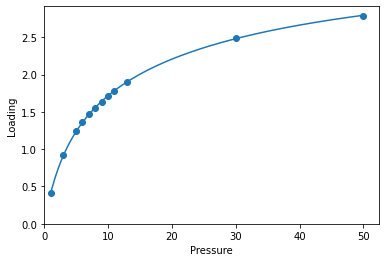

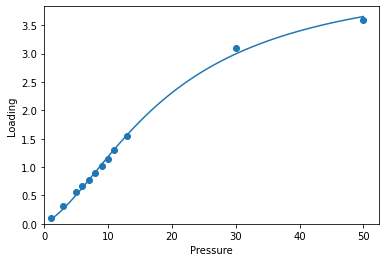

In [32]:
print(Names_CO2[1])
iso_AEI0_CO2 = bins_CO2[1][0]
iso_AEI0_CH4 = bins_CO2[1][1]

pyiast.plot_isotherm(iso_AEI0_CO2)
pyiast.plot_isotherm(iso_AEI0_CH4)


AEI_0


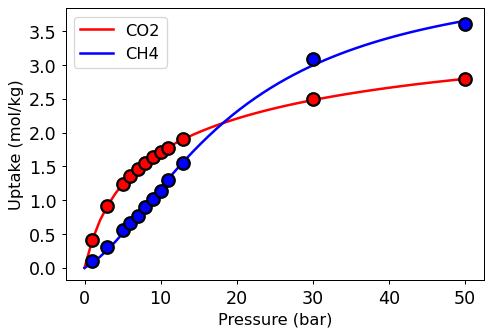

In [100]:
print(Names_CO2[1])
iso_ITW_CO2 = bins_CO2[1][0]
iso_ITW_CH4 = bins_CO2[1][1]

#pyiast.plot_isotherm(iso_ITW_CO2, xlogscale = True)
#pyiast.plot_isotherm(iso_ITW_CH4,xlogscale = True)

praw_CO2 = iso_ITW_CO2.df['P'].to_numpy()
qraw_CO2 = iso_ITW_CO2.df['q'].to_numpy()
praw_CH4 = iso_ITW_CH4.df['P'].to_numpy()
qraw_CH4 = iso_ITW_CH4.df['q'].to_numpy()

P_ran = np.linspace(0,50)
q_ran_CO2 = iso_ITW_CO2.loading(P_ran)
q_ran_CH4 = iso_ITW_CH4.loading(P_ran)

plt.figure(dpi = 90)
plt.plot(P_ran,q_ran_CO2, 'r-', linewidth = 2,label = 'CO2')
plt.plot(praw_CO2, qraw_CO2,
 'ro', markersize = 10, mec = 'k', markeredgewidth = 1.8)

plt.plot(P_ran,q_ran_CH4, 'b-',linewidth = 2,label = 'CH4')
plt.plot(praw_CH4, qraw_CH4, 
'bo', markersize = 10, mec = 'k', markeredgewidth = 1.8,)

plt.xlabel('Pressure (bar)',fontsize = 13)
plt.ylabel('Uptake (mol/kg)',fontsize = 13)

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.legend(fontsize = 13)

RRO_0


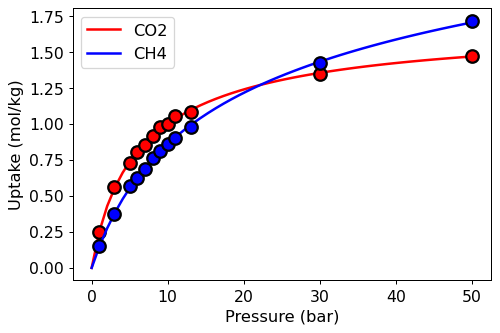

In [106]:
print(Names_CO2[256])
iso_RRO0_CO2 = bins_CO2[155][0]
iso_RRO0_CH4 = bins_CO2[155][1]

#pyiast.plot_isotherm(iso_ITW_CO2, xlogscale = True)
#pyiast.plot_isotherm(iso_ITW_CH4,xlogscale = True)

praw_CO2 = iso_RRO0_CO2.df['P'].to_numpy()
qraw_CO2 = iso_RRO0_CO2.df['q'].to_numpy()
praw_CH4 = iso_RRO0_CH4.df['P'].to_numpy()
qraw_CH4 = iso_RRO0_CH4.df['q'].to_numpy()

P_ran = np.linspace(0,50)
q_ran_CO2 = iso_RRO0_CO2.loading(P_ran)
q_ran_CH4 = iso_RRO0_CH4.loading(P_ran)

plt.figure(dpi = 90)
plt.plot(P_ran,q_ran_CO2, 'r-', linewidth = 2,label = 'CO2')
plt.plot(praw_CO2, qraw_CO2,
 'ro', markersize = 10, mec = 'k', markeredgewidth = 1.8)

plt.plot(P_ran,q_ran_CH4, 'b-',linewidth = 2,label = 'CH4')
plt.plot(praw_CH4, qraw_CH4, 
'bo', markersize = 10, mec = 'k', markeredgewidth = 1.8,)

plt.xlabel('Pressure (bar)',fontsize = 13)
plt.ylabel('Uptake (mol/kg)',fontsize = 13)

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.legend(fontsize = 13)

#plt.text(30,0.7,'Selectivity = ',fontdict={'size':13})


## AEI-0 case

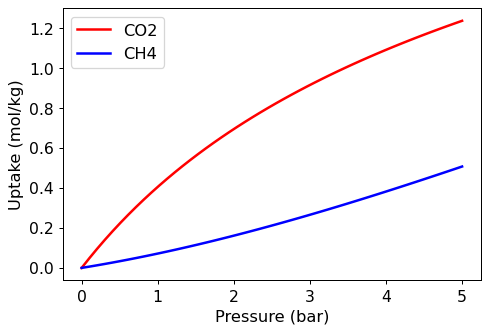

In [107]:
plt.figure(dpi = 90)

P_ran = np.linspace(0, 5)
xx_CO2 = iso_AEI0_CO2.loading(P_ran)
plt.plot(P_ran,xx_CO2,'r', linewidth = 2, label  = 'CO2')

xx_CH4 = iso_AEI0_CH4.loading(P_ran)
plt.plot(P_ran, xx_CH4,'b',linewidth = 2, label = 'CH4')


plt.xlabel('Pressure (bar)',fontsize = 13)
plt.ylabel('Uptake (mol/kg)',fontsize = 13)

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.legend(fontsize = 13)

## ITW-1 case

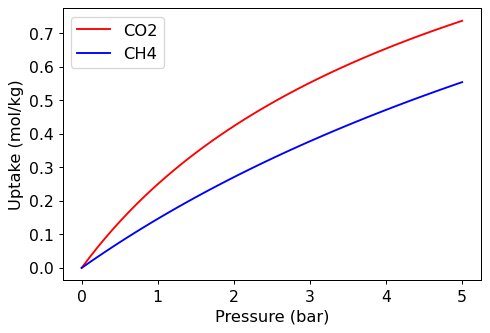

In [108]:
plt.figure(dpi = 90)

P_ran = np.linspace(0, 5)
xx_CO2 = iso_RRO0_CO2.loading(P_ran)
plt.plot(P_ran,xx_CO2, 'r', label = 'CO2')

xx_CH4 = iso_RRO0_CH4.loading(P_ran)
plt.plot(P_ran, xx_CH4,'b', label = 'CH4')

plt.xlabel('Pressure (bar)',fontsize = 13)
plt.ylabel('Uptake (mol/kg)',fontsize = 13)

plt.xticks(fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.legend(fontsize = 13)